In [161]:
# alpha:finish consulting; beta:new coming;
# overall timer format: (timepoint, event, stationid, serverid)

class Station:
    def __init__(self, stationid, overall_timer, process_param, n_server=0, n_buffer=0):
        self.stationid = stationid
        self.overall_timer = overall_timer
        self.s = n_server
        self.c = n_buffer
        self.wait = False
        self.status = [0, [0]*n_server] # 1 for occupied
        self.process_param = process_param
        self.next_station = None
    
    def setnext(self, next_station):
        self.next_station = next_station
        
    def printout(self):
        # print("time:{:.04f}".format(self.overall_timer[0][0]), " \tstation "+str(self.stationid)+":", self.status)
        return 0
    
    def update(self, timeslot):
        event= timeslot[1]
        if event == 'alpha':
            serverid = timeslot[3]
            self.alpha(serverid, timeslot)
        else:
            self.beta(timeslot)
        del(self.overall_timer[0])
        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
        
    def alpha(self, serverid, timeslot):
        if self.next_station == None:
            if self.status[0] > 0: # wqiting line is not empty
                self.status[0] -= 1
                try:
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                    self.printout()
                except:
                    print("empty process time list for station", self.stationid, "server", serverid)
            else:
                self.status[1][serverid] = 0
                self.printout()
                return True
        else:
            if self.next_station.beta(timeslot):
                if self.status[0] > 0: # waiting line is not empty
                    self.status[0] -= 1
                    try:
                        self.overall_timer.append((self.overall_timer[0][0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                        # del(self.process_times[0])
                        self.printout()
                    except:
                        print("empty process time list for station", self.stationid, "server", serverid)
                else:
                    self.status[1][serverid] = 0
                    self.printout()
                    return True
            else:
                for i in range(len(self.overall_timer)):
                    if self.overall_timer[i][2]==self.stationid+1:
                        self.overall_timer.append((self.overall_timer[i][0], 'alpha', self.stationid, serverid))
                        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
                        return True
                self.overall_timer.append((self.overall_timer[0][0], 'alpha', self.stationid, serverid))
                self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
            
    def beta(self, timeslot=None):
        if self.status[0] > 0: 
            if self.status[0]<self.c:
                self.status[0]+=1
                self.printout()
                return True
            else:
                return False
        else:
            i = 0
            while i < self.s:
                if self.status[1][i]==0:
                    self.status[1][i]=1
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, i))
                    # self.process_times.remove(self.process_times[0])
                    break
                else:
                    i += 1
            if i == self.s:
                self.status[0]+=1
            self.printout()
            return True
        

In [162]:
import numpy as np
class simulation:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [163]:
simulation.run(n_customers=1)

[(3, 'beta', 0)]
[(7.882007124751679, 'alpha', 0, 0)]
[(10.927510470444103, 'alpha', 1, 0)]
[(11.253304082374, 'alpha', 2, 0)]
[(12.722482197147112, 'alpha', 3, 0)]


12.722482197147112

In [164]:
import matplotlib.pyplot as plt
def conf_int_95(y):
    a = np.mean(y)
    b = np.sqrt(np.var(y, ddof=1))
    return (a-1.96*b, a+1.96*b)

[(0, 'beta', 0), (0, 'beta', 0), (2, 'beta', 0), (2, 'beta', 0), (2, 'beta', 0), (3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0)]
[(0, 'beta', 0), (2, 'beta', 0), (2, 'beta', 0), (2, 'beta', 0), (3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'alpha', 0, 0)]
[(2, 'beta', 0), (2, 'beta', 0), (2, 'beta', 0), (3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'alpha', 0, 0)]
[(2, 'beta', 0), (2, 'beta', 0), (3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'alpha', 0, 0)]
[(2, 'beta', 0), (3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'alpha', 0, 0)]
[(3, 'beta', 0), (3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'alpha', 0, 0)]
[(3, 'beta', 0), (4, 'beta', 0), (5, 'beta', 0), (7, 'beta', 0), (14.611944732279287, 'al

[(5.310023575004417, 'alpha', 1, 0), (5.413025319070168, 'alpha', 3, 0), (7.264602118293785, 'alpha', 0, 0)]
[(5.413025319070168, 'alpha', 3, 0), (5.515786221222254, 'alpha', 1, 0), (7.264602118293785, 'alpha', 0, 0), (10.199919880874482, 'alpha', 2, 0)]
[(5.515786221222254, 'alpha', 1, 0), (7.264602118293785, 'alpha', 0, 0), (10.199919880874482, 'alpha', 2, 0), (10.691315550666115, 'alpha', 3, 0)]
[(7.264602118293785, 'alpha', 0, 0), (8.627712512301231, 'alpha', 1, 0), (10.199919880874482, 'alpha', 2, 0), (10.691315550666115, 'alpha', 3, 0)]
[(8.627712512301231, 'alpha', 1, 0), (10.166213632954271, 'alpha', 0, 0), (10.199919880874482, 'alpha', 2, 0), (10.691315550666115, 'alpha', 3, 0)]
[(9.287243643508187, 'alpha', 1, 0), (10.166213632954271, 'alpha', 0, 0), (10.199919880874482, 'alpha', 2, 0), (10.691315550666115, 'alpha', 3, 0)]
[(9.868268955371628, 'alpha', 1, 0), (10.166213632954271, 'alpha', 0, 0), (10.199919880874482, 'alpha', 2, 0), (10.691315550666115, 'alpha', 3, 0)]
[(10.16

[(3, 'beta', 0), (4, 'beta', 0), (4.178729859615785, 'alpha', 0, 0), (5, 'beta', 0)]
[(4, 'beta', 0), (4.178729859615785, 'alpha', 0, 0), (5, 'beta', 0)]
[(4.178729859615785, 'alpha', 0, 0), (5, 'beta', 0)]
[(4.332283224726798, 'alpha', 1, 0), (5, 'beta', 0), (5.813947361804261, 'alpha', 0, 0)]
[(4.459048800087892, 'alpha', 2, 0), (5, 'beta', 0), (5.813947361804261, 'alpha', 0, 0)]
[(4.806005034333537, 'alpha', 3, 0), (5, 'beta', 0), (5.813947361804261, 'alpha', 0, 0)]
[(5, 'beta', 0), (5.813947361804261, 'alpha', 0, 0)]
[(5.813947361804261, 'alpha', 0, 0)]
[(6.924565589619036, 'alpha', 1, 0), (9.864562400594718, 'alpha', 0, 0)]
[(9.864562400594718, 'alpha', 0, 0), (10.823325278843265, 'alpha', 2, 0)]
[(9.938593144510254, 'alpha', 0, 0), (10.823325278843265, 'alpha', 2, 0), (10.874056074573385, 'alpha', 1, 0)]
[(10.823325278843265, 'alpha', 2, 0), (10.874056074573385, 'alpha', 1, 0), (14.269847802196168, 'alpha', 0, 0)]
[(10.874056074573385, 'alpha', 1, 0), (14.269847802196168, 'alpha'

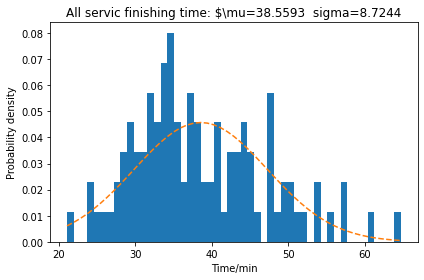

In [166]:
x0 = []
for i in range(100):
    x0.append(simulation.run(n_customers=10))
x = np.array(x0)
print(conf_int_95(x))

num_bins =  50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

[(3, 'beta', 0)]
[(3.3064754870557356, 'alpha', 0, 0)]
[(3.384409508993212, 'alpha', 1, 0)]
[(7.417441539578132, 'alpha', 2, 0)]
[(10.663126837210168, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(5.085897751446712, 'alpha', 0, 0)]
[(7.232237835564125, 'alpha', 1, 0)]
[(7.362221565957648, 'alpha', 2, 0)]
[(8.083118775023717, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(8.438441374048029, 'alpha', 0, 0)]
[(10.634203890209964, 'alpha', 1, 0)]
[(11.695624571647258, 'alpha', 2, 0)]
[(11.866240998405841, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.07239511573753, 'alpha', 0, 0)]
[(6.0378391121841375, 'alpha', 1, 0)]
[(10.15072074971577, 'alpha', 2, 0)]
[(12.899452092694624, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.4978874138786662, 'alpha', 0, 0)]
[(5.158166430054011, 'alpha', 1, 0)]
[(7.512194896991954, 'alpha', 2, 0)]
[(12.393343473122727, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(9.167429039202512, 'alpha', 0, 0)]
[(12.978494438807058, 'alpha', 1, 0)]
[(13.898663294276801, 'alpha', 2, 0)]
[(19.237495245520144, 'alpha', 3, 0)]

[(4, 'beta', 0)]
[(7.5141915168800395, 'alpha', 0, 0)]
[(7.666979805535628, 'alpha', 1, 0)]
[(11.663252934976777, 'alpha', 2, 0)]
[(16.498751481555363, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(2.9393740200668996, 'alpha', 0, 0)]
[(4.876770967666667, 'alpha', 1, 0)]
[(5.5267905442270555, 'alpha', 2, 0)]
[(13.24908141450843, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.118830677733425, 'alpha', 0, 0)]
[(7.984553697149748, 'alpha', 1, 0)]
[(8.292700294792345, 'alpha', 2, 0)]
[(8.364225362240624, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(8.07380597490933, 'alpha', 0, 0)]
[(10.44549278975582, 'alpha', 1, 0)]
[(12.166775562910344, 'alpha', 2, 0)]
[(19.792244123802654, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.564118742782904, 'alpha', 0, 0)]
[(5.592142519129307, 'alpha', 1, 0)]
[(5.947782089168194, 'alpha', 2, 0)]
[(6.557184571826258, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.4168932095686504, 'alpha', 0, 0)]
[(4.178711873077979, 'alpha', 1, 0)]
[(4.734199440565718, 'alpha', 2, 0)]
[(4.920627843783288, 'alpha', 3, 0)]
[(2

[(11.029858402437206, 'alpha', 2, 0)]
[(12.376286475358894, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.898155728024779, 'alpha', 0, 0)]
[(10.244787263086426, 'alpha', 1, 0)]
[(11.843027328518195, 'alpha', 2, 0)]
[(17.116702986016783, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.453622078934484, 'alpha', 0, 0)]
[(5.132726199750583, 'alpha', 1, 0)]
[(5.552891696289042, 'alpha', 2, 0)]
[(10.308904016890693, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.256577321348818, 'alpha', 0, 0)]
[(4.294035224136749, 'alpha', 1, 0)]
[(13.379015039059082, 'alpha', 2, 0)]
[(14.751394783959576, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(8.613401132065459, 'alpha', 0, 0)]
[(10.190650574274542, 'alpha', 1, 0)]
[(11.260249983550503, 'alpha', 2, 0)]
[(12.26397822610334, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.285967594793736, 'alpha', 0, 0)]
[(7.771497716765706, 'alpha', 1, 0)]
[(8.340138514201334, 'alpha', 2, 0)]
[(8.604109396173726, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(4.218672183276193, 'alpha', 0, 0)]
[(4.630643502407229, 'alpha', 1, 0)]


[(9.017943412937633, 'alpha', 0, 0)]
[(9.653011999114751, 'alpha', 1, 0)]
[(13.83493851555045, 'alpha', 2, 0)]
[(22.768194504816968, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.3077484166333333, 'alpha', 0, 0)]
[(8.325157686502653, 'alpha', 1, 0)]
[(10.630870616354507, 'alpha', 2, 0)]
[(16.353316255157, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(6.059821468419435, 'alpha', 0, 0)]
[(7.383951191871385, 'alpha', 1, 0)]
[(11.432885277004736, 'alpha', 2, 0)]
[(12.189401205251379, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.146210937140324, 'alpha', 0, 0)]
[(5.598924386857455, 'alpha', 1, 0)]
[(6.005792016027985, 'alpha', 2, 0)]
[(9.322230800263377, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(10.2500803116957, 'alpha', 0, 0)]
[(16.73873177715995, 'alpha', 1, 0)]
[(17.605319341470377, 'alpha', 2, 0)]
[(18.866064600061932, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.7708414994743698, 'alpha', 0, 0)]
[(7.654265776058976, 'alpha', 1, 0)]
[(9.4764212134486, 'alpha', 2, 0)]
[(10.590792936361451, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(14.2

[(4, 'beta', 0)]
[(8.928639471678604, 'alpha', 0, 0)]
[(11.607618266627222, 'alpha', 1, 0)]
[(13.232939630150366, 'alpha', 2, 0)]
[(16.36157826861358, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.056669089755651, 'alpha', 0, 0)]
[(5.182923474343493, 'alpha', 1, 0)]
[(6.5004405914308645, 'alpha', 2, 0)]
[(7.130902836089658, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.886023443187583, 'alpha', 0, 0)]
[(5.606863530732181, 'alpha', 1, 0)]
[(12.054195628210438, 'alpha', 2, 0)]
[(17.413486019509005, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.579139561469153, 'alpha', 0, 0)]
[(4.9642120496681095, 'alpha', 1, 0)]
[(4.984234942976894, 'alpha', 2, 0)]
[(7.920939892850745, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.7702198308587583, 'alpha', 0, 0)]
[(2.3972048161810533, 'alpha', 1, 0)]
[(5.13049525964028, 'alpha', 2, 0)]
[(6.406802955999456, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.0978224584410494, 'alpha', 0, 0)]
[(2.5577314326687177, 'alpha', 1, 0)]
[(3.241020958850292, 'alpha', 2, 0)]
[(5.399684438594444, 'alpha', 3, 0)]
[

[(13.8662019112598, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(4.414434802827054, 'alpha', 0, 0)]
[(4.6172904387152816, 'alpha', 1, 0)]
[(5.233914890434025, 'alpha', 2, 0)]
[(7.564645948487122, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.612146401359061, 'alpha', 0, 0)]
[(8.349637249057961, 'alpha', 1, 0)]
[(9.124275219565082, 'alpha', 2, 0)]
[(10.313531715713838, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.113952345124775, 'alpha', 0, 0)]
[(2.56543441631159, 'alpha', 1, 0)]
[(4.657700472593914, 'alpha', 2, 0)]
[(5.715036674524036, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(9.25548293167488, 'alpha', 0, 0)]
[(9.837024398683875, 'alpha', 1, 0)]
[(13.418225519263594, 'alpha', 2, 0)]
[(14.671606797827234, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.750757525826053, 'alpha', 0, 0)]
[(10.604093280495391, 'alpha', 1, 0)]
[(15.61692469388815, 'alpha', 2, 0)]
[(18.439527671220304, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(6.185364267813574, 'alpha', 0, 0)]
[(13.871068188854629, 'alpha', 1, 0)]
[(15.129638768036395, 'alpha', 2, 0)]
[(17.

[(11.176419409861879, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.1330694825138548, 'alpha', 0, 0)]
[(3.3431750570645145, 'alpha', 1, 0)]
[(7.245288986635089, 'alpha', 2, 0)]
[(7.554096072507385, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(3.5956142059812017, 'alpha', 0, 0)]
[(5.684422190584592, 'alpha', 1, 0)]
[(8.400288353310465, 'alpha', 2, 0)]
[(9.229862456003062, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.7598982969660897, 'alpha', 0, 0)]
[(3.2826049641508415, 'alpha', 1, 0)]
[(4.573548189773317, 'alpha', 2, 0)]
[(7.154193780054975, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.9913656426071046, 'alpha', 0, 0)]
[(2.8183644470213802, 'alpha', 1, 0)]
[(3.016570603543114, 'alpha', 2, 0)]
[(3.477817806916277, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(8.734594556349744, 'alpha', 0, 0)]
[(15.154856108909527, 'alpha', 1, 0)]
[(18.951313079267422, 'alpha', 2, 0)]
[(19.4972309472142, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.682187062792592, 'alpha', 0, 0)]
[(3.3731984849947927, 'alpha', 1, 0)]
[(5.806017082479418, 'alpha', 2, 0)]


[(9.454842597587193, 'alpha', 2, 0)]
[(12.172027523686157, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.9543177018255038, 'alpha', 0, 0)]
[(0.9966623535280696, 'alpha', 1, 0)]
[(2.259282821027222, 'alpha', 2, 0)]
[(7.0510605549246295, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.604802220270274, 'alpha', 0, 0)]
[(5.143783075273339, 'alpha', 1, 0)]
[(8.557759404793455, 'alpha', 2, 0)]
[(11.224026134368756, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.181162747777079, 'alpha', 0, 0)]
[(5.724584607319549, 'alpha', 1, 0)]
[(12.307977512328353, 'alpha', 2, 0)]
[(18.33339188472946, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.6145566780372946, 'alpha', 0, 0)]
[(12.68630381000244, 'alpha', 1, 0)]
[(13.153569144764917, 'alpha', 2, 0)]
[(16.98585391073872, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.6433876306061332, 'alpha', 0, 0)]
[(6.193894555390771, 'alpha', 1, 0)]
[(8.690689055930761, 'alpha', 2, 0)]
[(9.552666226999584, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(9.700001970339226, 'alpha', 0, 0)]
[(12.624155679892864, 'alpha', 1, 0)]


[(14.42055645901209, 'alpha', 2, 0)]
[(23.879547997290935, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.0545053581589414, 'alpha', 0, 0)]
[(6.31131604802237, 'alpha', 1, 0)]
[(7.485362178628281, 'alpha', 2, 0)]
[(9.788033226701312, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.16194230896658, 'alpha', 0, 0)]
[(9.318202938860594, 'alpha', 1, 0)]
[(10.487308452793851, 'alpha', 2, 0)]
[(16.453483508902927, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.5175742385821445, 'alpha', 0, 0)]
[(2.8886908586840327, 'alpha', 1, 0)]
[(5.14320797024474, 'alpha', 2, 0)]
[(5.933415324629184, 'alpha', 3, 0)]
[(6, 'beta', 0)]
[(7.3854942954068505, 'alpha', 0, 0)]
[(9.129622782702807, 'alpha', 1, 0)]
[(10.44529918941055, 'alpha', 2, 0)]
[(10.867284531277518, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(7.182422562494093, 'alpha', 0, 0)]
[(11.335036094591302, 'alpha', 1, 0)]
[(14.486079033545561, 'alpha', 2, 0)]
[(15.155649286265046, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(6.243115776018012, 'alpha', 0, 0)]
[(8.53475028499147, 'alpha', 1, 0)]
[(9

[(18.055680472479885, 'alpha', 1, 0)]
[(19.4648756518397, 'alpha', 2, 0)]
[(19.835412797596547, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.30515084911977, 'alpha', 0, 0)]
[(4.668626383667832, 'alpha', 1, 0)]
[(9.035534626276506, 'alpha', 2, 0)]
[(9.795567905461501, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(7.075459612252143, 'alpha', 0, 0)]
[(11.593886915882585, 'alpha', 1, 0)]
[(20.776423984197343, 'alpha', 2, 0)]
[(24.891388259751015, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.3642922900458396, 'alpha', 0, 0)]
[(2.4421634145827964, 'alpha', 1, 0)]
[(5.243375042412226, 'alpha', 2, 0)]
[(5.990901008483665, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.6021114146870754, 'alpha', 0, 0)]
[(2.249175721789395, 'alpha', 1, 0)]
[(2.5052466677798613, 'alpha', 2, 0)]
[(3.264462949285887, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(6.212938076936454, 'alpha', 0, 0)]
[(7.166344068302361, 'alpha', 1, 0)]
[(7.945018853213084, 'alpha', 2, 0)]
[(8.971188933518954, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(6.2163419347798685, 'alpha', 0, 0)]
[(

[(12.499157547610643, 'alpha', 2, 0)]
[(16.150861501517873, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.2908301032115177, 'alpha', 0, 0)]
[(7.120303382759678, 'alpha', 1, 0)]
[(8.62745432549069, 'alpha', 2, 0)]
[(9.891078180491363, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.7204405977850854, 'alpha', 0, 0)]
[(1.7073366511969774, 'alpha', 1, 0)]
[(3.9113356754956907, 'alpha', 2, 0)]
[(6.830225467798586, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.096966431096981, 'alpha', 0, 0)]
[(10.182678001814553, 'alpha', 1, 0)]
[(10.90539732103498, 'alpha', 2, 0)]
[(13.984693689607484, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(7.22501907097325, 'alpha', 0, 0)]
[(7.78869250431446, 'alpha', 1, 0)]
[(9.610154997981782, 'alpha', 2, 0)]
[(9.987641747196093, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.2658255756784365, 'alpha', 0, 0)]
[(14.755073401758516, 'alpha', 1, 0)]
[(17.818986528639677, 'alpha', 2, 0)]
[(18.1017522836225, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.632405580848065, 'alpha', 0, 0)]
[(6.872218689061749, 'alpha', 1, 0)]
[(1

[(11.340795597647423, 'alpha', 1, 0)]
[(12.321434828131203, 'alpha', 2, 0)]
[(12.609125272631829, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.0418881144870538, 'alpha', 0, 0)]
[(6.49854524569511, 'alpha', 1, 0)]
[(8.748630860771119, 'alpha', 2, 0)]
[(9.483247063299041, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.1574994682998894, 'alpha', 0, 0)]
[(1.3998825652716924, 'alpha', 1, 0)]
[(4.457842125035807, 'alpha', 2, 0)]
[(6.166486039428885, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(2.7870222859185287, 'alpha', 0, 0)]
[(3.49316876290924, 'alpha', 1, 0)]
[(3.7829818712759407, 'alpha', 2, 0)]
[(14.48253096997238, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(2.7723650950626104, 'alpha', 0, 0)]
[(5.010179034436295, 'alpha', 1, 0)]
[(5.855665504330664, 'alpha', 2, 0)]
[(9.246377018015513, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.27129488827074, 'alpha', 0, 0)]
[(3.1740876299278895, 'alpha', 1, 0)]
[(3.6650620653597334, 'alpha', 2, 0)]
[(5.671288853393399, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(6.921530615948502, 'alpha', 0, 0)]
[(

[(3.154141935504012, 'alpha', 1, 0)]
[(4.57441042773698, 'alpha', 2, 0)]
[(5.359668441585867, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.125994209097965, 'alpha', 0, 0)]
[(2.7535820343266653, 'alpha', 1, 0)]
[(6.368273511918543, 'alpha', 2, 0)]
[(10.166335559240352, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(12.651428841849391, 'alpha', 0, 0)]
[(13.34570327702758, 'alpha', 1, 0)]
[(15.323085392053203, 'alpha', 2, 0)]
[(19.829233207659225, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.952364455377981, 'alpha', 0, 0)]
[(6.155006078646354, 'alpha', 1, 0)]
[(6.918089148293538, 'alpha', 2, 0)]
[(8.1161147380319, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.896603264963357, 'alpha', 0, 0)]
[(5.318892453945843, 'alpha', 1, 0)]
[(7.554987331412955, 'alpha', 2, 0)]
[(8.81426941733033, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(6.884874911595819, 'alpha', 0, 0)]
[(6.968802284623708, 'alpha', 1, 0)]
[(16.549218316087227, 'alpha', 2, 0)]
[(16.742607207845257, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(4.522155467539845, 'alpha', 0, 0)]
[(4.613

[(2, 'beta', 0)]
[(4.815188595342533, 'alpha', 0, 0)]
[(5.089398684346077, 'alpha', 1, 0)]
[(5.447774832794904, 'alpha', 2, 0)]
[(11.965255459833084, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.3479523818517631, 'alpha', 0, 0)]
[(2.2396118744484745, 'alpha', 1, 0)]
[(3.579165077060412, 'alpha', 2, 0)]
[(6.4828523280202095, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(7.034245479691019, 'alpha', 0, 0)]
[(9.048209502898674, 'alpha', 1, 0)]
[(16.30879815308828, 'alpha', 2, 0)]
[(20.90069258707772, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(7.426060094215534, 'alpha', 0, 0)]
[(8.082991120312931, 'alpha', 1, 0)]
[(9.710844939571285, 'alpha', 2, 0)]
[(10.514729959998629, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(3.2040498022460757, 'alpha', 0, 0)]
[(8.932363548984297, 'alpha', 1, 0)]
[(11.337784195269867, 'alpha', 2, 0)]
[(12.365365336722903, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(12.92616574188157, 'alpha', 0, 0)]
[(12.979281351850464, 'alpha', 1, 0)]
[(14.487924407122527, 'alpha', 2, 0)]
[(16.2669605117875, 'alpha', 3, 0)]
[

[(7, 'beta', 0)]
[(10.419960469251299, 'alpha', 0, 0)]
[(13.110019805258343, 'alpha', 1, 0)]
[(13.76106768515383, 'alpha', 2, 0)]
[(13.938246718697826, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.7384341569615325, 'alpha', 0, 0)]
[(8.973296140851474, 'alpha', 1, 0)]
[(9.847727294484006, 'alpha', 2, 0)]
[(13.176955396392096, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.8516742070027594, 'alpha', 0, 0)]
[(5.870001597387645, 'alpha', 1, 0)]
[(6.376632686228426, 'alpha', 2, 0)]
[(7.687351436490319, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(8.166109546895608, 'alpha', 0, 0)]
[(8.807731665756746, 'alpha', 1, 0)]
[(15.245766536029876, 'alpha', 2, 0)]
[(15.384647226565917, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.242770914309009, 'alpha', 0, 0)]
[(8.061371467994455, 'alpha', 1, 0)]
[(11.204456301453813, 'alpha', 2, 0)]
[(11.309781317283294, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.9123076025140295, 'alpha', 0, 0)]
[(3.017680177191222, 'alpha', 1, 0)]
[(10.376290322835748, 'alpha', 2, 0)]
[(14.474596837523883, 'alpha', 3, 0

[(4, 'beta', 0)]
[(4.223843151264322, 'alpha', 0, 0)]
[(9.686809508142638, 'alpha', 1, 0)]
[(10.35748064128161, 'alpha', 2, 0)]
[(14.126391097079509, 'alpha', 3, 0)]
[(7, 'beta', 0)]
[(13.283617897667664, 'alpha', 0, 0)]
[(17.07048628340695, 'alpha', 1, 0)]
[(17.479058304891826, 'alpha', 2, 0)]
[(17.953149187303804, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.625319189784723, 'alpha', 0, 0)]
[(24.915536385702875, 'alpha', 1, 0)]
[(28.455739409616434, 'alpha', 2, 0)]
[(29.08377287557381, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.4538224292730977, 'alpha', 0, 0)]
[(5.796823039990685, 'alpha', 1, 0)]
[(5.995349149473623, 'alpha', 2, 0)]
[(7.480861081879849, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(9.764092593263173, 'alpha', 0, 0)]
[(10.350035797926994, 'alpha', 1, 0)]
[(11.434686045739912, 'alpha', 2, 0)]
[(13.991882184855593, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.5387464076827538, 'alpha', 0, 0)]
[(3.177126512959645, 'alpha', 1, 0)]
[(3.8186465289880025, 'alpha', 2, 0)]
[(7.592754479625741, 'alpha', 3, 0)

[(11.126715008375964, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(14.285024840491342, 'alpha', 0, 0)]
[(17.5662434199725, 'alpha', 1, 0)]
[(18.28827534613744, 'alpha', 2, 0)]
[(18.308883732782743, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(11.700220904092244, 'alpha', 0, 0)]
[(13.30183805281825, 'alpha', 1, 0)]
[(14.414345317205235, 'alpha', 2, 0)]
[(16.616439795274356, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(6.295824567527384, 'alpha', 0, 0)]
[(10.945995407382084, 'alpha', 1, 0)]
[(12.116940341732521, 'alpha', 2, 0)]
[(12.46802934861768, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.8821150020090913, 'alpha', 0, 0)]
[(2.2893663791887615, 'alpha', 1, 0)]
[(5.971346874498936, 'alpha', 2, 0)]
[(8.45812179499688, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.4495892382070459, 'alpha', 0, 0)]
[(9.726735804870493, 'alpha', 1, 0)]
[(10.052260031933518, 'alpha', 2, 0)]
[(11.107903203124522, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.291370018687636, 'alpha', 0, 0)]
[(8.352899093425306, 'alpha', 1, 0)]
[(10.196908368536738, 'alpha', 2, 0)

[(2.662376313375532, 'alpha', 1, 0)]
[(6.189940712509981, 'alpha', 2, 0)]
[(8.05993385843673, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.553629285471742, 'alpha', 0, 0)]
[(4.4723331066502325, 'alpha', 1, 0)]
[(4.557600443040042, 'alpha', 2, 0)]
[(9.071390742007665, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.027927026849966, 'alpha', 0, 0)]
[(5.396542587524649, 'alpha', 1, 0)]
[(8.230643850701162, 'alpha', 2, 0)]
[(10.944221845141634, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.3012358319255248, 'alpha', 0, 0)]
[(4.540623849710571, 'alpha', 1, 0)]
[(7.365395613956277, 'alpha', 2, 0)]
[(10.470473822308977, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.0000524507623623, 'alpha', 0, 0)]
[(3.731292858575469, 'alpha', 1, 0)]
[(7.06889750802482, 'alpha', 2, 0)]
[(8.356975462741088, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.9204831257444678, 'alpha', 0, 0)]
[(2.0799230130908497, 'alpha', 1, 0)]
[(2.109253440866687, 'alpha', 2, 0)]
[(2.2867866012040956, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.2982910181132725, 'alpha', 0, 0)]
[(4

[(7.59603450053985, 'alpha', 0, 0)]
[(10.266844495443847, 'alpha', 1, 0)]
[(13.152048844029107, 'alpha', 2, 0)]
[(20.884927468198402, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.077985016940426, 'alpha', 0, 0)]
[(4.415364280081847, 'alpha', 1, 0)]
[(5.041673923109903, 'alpha', 2, 0)]
[(10.025617295339485, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.3038858541968406, 'alpha', 0, 0)]
[(3.4781293431238853, 'alpha', 1, 0)]
[(4.074168926767102, 'alpha', 2, 0)]
[(4.097256493629331, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.4378658936538775, 'alpha', 0, 0)]
[(9.078230209540273, 'alpha', 1, 0)]
[(10.980059460322622, 'alpha', 2, 0)]
[(12.328205671289506, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(8.056210532827638, 'alpha', 0, 0)]
[(10.18159288551509, 'alpha', 1, 0)]
[(10.768409702455102, 'alpha', 2, 0)]
[(11.494428689744543, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.218516664531228, 'alpha', 0, 0)]
[(5.90154921724292, 'alpha', 1, 0)]
[(10.638911979956353, 'alpha', 2, 0)]
[(10.723196697786188, 'alpha', 3, 0)]
[(2, 'beta', 0)]

[(7.650977598425984, 'alpha', 1, 0)]
[(9.851634188923455, 'alpha', 2, 0)]
[(12.47200406259704, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.354213051139234, 'alpha', 0, 0)]
[(4.866080472958531, 'alpha', 1, 0)]
[(6.908229428581232, 'alpha', 2, 0)]
[(8.59687194546147, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.550802411832716, 'alpha', 0, 0)]
[(7.7976018639041715, 'alpha', 1, 0)]
[(12.79016758917596, 'alpha', 2, 0)]
[(18.34893533863061, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(2.0408542524012017, 'alpha', 0, 0)]
[(5.974783113236425, 'alpha', 1, 0)]
[(8.357854591987124, 'alpha', 2, 0)]
[(9.075882767435917, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.0833059028689918, 'alpha', 0, 0)]
[(3.188416628074245, 'alpha', 1, 0)]
[(5.417870232766578, 'alpha', 2, 0)]
[(6.363033386160703, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.850656026254292, 'alpha', 0, 0)]
[(11.570633204426468, 'alpha', 1, 0)]
[(15.167682490737825, 'alpha', 2, 0)]
[(15.193310990624258, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(9.39671500094747, 'alpha', 0, 0)]
[(16.6

[(3.306236782955911, 'alpha', 0, 0)]
[(6.271280406626257, 'alpha', 1, 0)]
[(8.15623377275914, 'alpha', 2, 0)]
[(8.99640638014108, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.929177034127439, 'alpha', 0, 0)]
[(12.484851385209833, 'alpha', 1, 0)]
[(12.665719803328507, 'alpha', 2, 0)]
[(13.306838273801514, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.372041856211739, 'alpha', 0, 0)]
[(7.961588696974525, 'alpha', 1, 0)]
[(12.053844906560617, 'alpha', 2, 0)]
[(12.222042531639056, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.0761848047354134, 'alpha', 0, 0)]
[(3.0789047834203296, 'alpha', 1, 0)]
[(5.378326257685891, 'alpha', 2, 0)]
[(5.79343754730834, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(8.37200866722457, 'alpha', 0, 0)]
[(8.493086249743882, 'alpha', 1, 0)]
[(9.078662819463862, 'alpha', 2, 0)]
[(9.384761891559137, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(8.035425358399674, 'alpha', 0, 0)]
[(9.341857314741771, 'alpha', 1, 0)]
[(12.079999834381997, 'alpha', 2, 0)]
[(12.925604580757916, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.2

[(9.138255652727887, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(7.619648480623818, 'alpha', 0, 0)]
[(8.093601308500215, 'alpha', 1, 0)]
[(8.60199147763382, 'alpha', 2, 0)]
[(17.534725856801888, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.859321074326878, 'alpha', 0, 0)]
[(5.97007461275727, 'alpha', 1, 0)]
[(8.712787579751522, 'alpha', 2, 0)]
[(10.833490371600307, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(10.06505651952418, 'alpha', 0, 0)]
[(12.388039023614546, 'alpha', 1, 0)]
[(15.737605808391521, 'alpha', 2, 0)]
[(16.044874107216543, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.061567647224642, 'alpha', 0, 0)]
[(3.6572330887719495, 'alpha', 1, 0)]
[(4.917227127667312, 'alpha', 2, 0)]
[(6.772054993854857, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.006905765157227195, 'alpha', 0, 0)]
[(3.435879509556025, 'alpha', 1, 0)]
[(9.10826459225165, 'alpha', 2, 0)]
[(14.563238330704863, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.47804997382069514, 'alpha', 0, 0)]
[(4.263416295379956, 'alpha', 1, 0)]
[(7.477712577281168, 'alpha', 2, 0)]
[

[(3, 'beta', 0)]
[(3.201136840147, 'alpha', 0, 0)]
[(4.4165140139903105, 'alpha', 1, 0)]
[(4.608713121645012, 'alpha', 2, 0)]
[(5.287670762789103, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.197197567475923, 'alpha', 0, 0)]
[(2.5082424729671917, 'alpha', 1, 0)]
[(4.45463808549566, 'alpha', 2, 0)]
[(5.3909978685616275, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.2975366272219895, 'alpha', 0, 0)]
[(5.076159308851487, 'alpha', 1, 0)]
[(5.1532545359306186, 'alpha', 2, 0)]
[(5.378347498497431, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.2938729668374462, 'alpha', 0, 0)]
[(2.2572660473810933, 'alpha', 1, 0)]
[(5.560156044979202, 'alpha', 2, 0)]
[(7.901946891152157, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.5073874026557923, 'alpha', 0, 0)]
[(5.120175024878163, 'alpha', 1, 0)]
[(6.3112579815745224, 'alpha', 2, 0)]
[(8.042783391687387, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.420095860434519, 'alpha', 0, 0)]
[(7.840808706489104, 'alpha', 1, 0)]
[(10.956085115076064, 'alpha', 2, 0)]
[(11.584124311879613, 'alpha', 3, 0)]
[(2

[(1, 'beta', 0)]
[(3.365687716018076, 'alpha', 0, 0)]
[(3.9632679164830913, 'alpha', 1, 0)]
[(8.735211868055487, 'alpha', 2, 0)]
[(11.90419586674182, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.827966942211505, 'alpha', 0, 0)]
[(4.341644030632801, 'alpha', 1, 0)]
[(6.256778201854485, 'alpha', 2, 0)]
[(7.255953488060889, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(8.402011086145546, 'alpha', 0, 0)]
[(10.172830889616339, 'alpha', 1, 0)]
[(11.088445995597489, 'alpha', 2, 0)]
[(17.319429919157212, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.613084364270469, 'alpha', 0, 0)]
[(8.028639285819862, 'alpha', 1, 0)]
[(12.981103339575156, 'alpha', 2, 0)]
[(16.272343468942847, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.4325984709535848, 'alpha', 0, 0)]
[(2.1010667416558855, 'alpha', 1, 0)]
[(3.8190867453206003, 'alpha', 2, 0)]
[(10.663479046404323, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(6.513447778876736, 'alpha', 0, 0)]
[(6.861622354368426, 'alpha', 1, 0)]
[(10.165064178604178, 'alpha', 2, 0)]
[(10.513926493562947, 'alpha', 3, 0)

[(13.347559560718285, 'alpha', 2, 0)]
[(13.685181113297537, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.5588621420296824, 'alpha', 0, 0)]
[(5.401286921349301, 'alpha', 1, 0)]
[(10.33909885235812, 'alpha', 2, 0)]
[(12.235690400974056, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.2675222593152329, 'alpha', 0, 0)]
[(3.001743756530945, 'alpha', 1, 0)]
[(3.0398556360066773, 'alpha', 2, 0)]
[(5.375574124501686, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(8.547794223830511, 'alpha', 0, 0)]
[(10.882507229356301, 'alpha', 1, 0)]
[(13.330721957906576, 'alpha', 2, 0)]
[(18.16672645167231, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(3.046274431519474, 'alpha', 0, 0)]
[(5.547413167812708, 'alpha', 1, 0)]
[(5.756632383602878, 'alpha', 2, 0)]
[(7.6521893055952805, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.9872057330895254, 'alpha', 0, 0)]
[(6.490003365866224, 'alpha', 1, 0)]
[(7.296627912129165, 'alpha', 2, 0)]
[(9.23212646473043, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.168722583737784, 'alpha', 0, 0)]
[(10.146013232248361, 'alpha', 1, 0)]


[(22.191738680374417, 'alpha', 0, 0)]
[(25.372263414329584, 'alpha', 1, 0)]
[(27.483691133073513, 'alpha', 2, 0)]
[(34.28769390075648, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.638422296822879, 'alpha', 0, 0)]
[(5.773571618421351, 'alpha', 1, 0)]
[(10.439452369482012, 'alpha', 2, 0)]
[(12.776557446858995, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(7.88030289643691, 'alpha', 0, 0)]
[(9.144279026247546, 'alpha', 1, 0)]
[(10.627999922533167, 'alpha', 2, 0)]
[(11.016852552551523, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.1964045457352284, 'alpha', 0, 0)]
[(4.332240692688012, 'alpha', 1, 0)]
[(7.112833942467941, 'alpha', 2, 0)]
[(7.656064071008969, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.4791401320746929, 'alpha', 0, 0)]
[(1.72022549327779, 'alpha', 1, 0)]
[(2.448212636559216, 'alpha', 2, 0)]
[(4.7702227668893915, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(11.526580780553301, 'alpha', 0, 0)]
[(14.103522613365463, 'alpha', 1, 0)]
[(15.079454021700323, 'alpha', 2, 0)]
[(27.346211707713596, 'alpha', 3, 0)]
[(2, 'beta', 0)

[(1, 'beta', 0)]
[(1.1442237545703386, 'alpha', 0, 0)]
[(9.1331403474188, 'alpha', 1, 0)]
[(10.421995429331378, 'alpha', 2, 0)]
[(16.69187227357604, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.986262293201229, 'alpha', 0, 0)]
[(5.98183346595254, 'alpha', 1, 0)]
[(7.5694743893002405, 'alpha', 2, 0)]
[(16.880702803588637, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.0775314145042145, 'alpha', 0, 0)]
[(9.673187753577817, 'alpha', 1, 0)]
[(10.730102497474272, 'alpha', 2, 0)]
[(12.405087334658605, 'alpha', 3, 0)]
[(7, 'beta', 0)]
[(7.097885941065178, 'alpha', 0, 0)]
[(8.877519251652611, 'alpha', 1, 0)]
[(9.749121440012877, 'alpha', 2, 0)]
[(12.781257799297887, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(11.83654179595825, 'alpha', 0, 0)]
[(18.714841575645256, 'alpha', 1, 0)]
[(21.95918989500826, 'alpha', 2, 0)]
[(22.2675269913425, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.9466120707458465, 'alpha', 0, 0)]
[(7.9826940160266115, 'alpha', 1, 0)]
[(11.112676656175694, 'alpha', 2, 0)]
[(20.30480689949047, 'alpha', 3, 0)]
[(

[(1, 'beta', 0)]
[(3.414223682651404, 'alpha', 0, 0)]
[(6.42463763634521, 'alpha', 1, 0)]
[(8.529005371288495, 'alpha', 2, 0)]
[(9.974632192700783, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.624373459227897, 'alpha', 0, 0)]
[(5.823976700513376, 'alpha', 1, 0)]
[(12.511154837452583, 'alpha', 2, 0)]
[(16.50549032471344, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.4537054966229845, 'alpha', 0, 0)]
[(5.958270080765135, 'alpha', 1, 0)]
[(6.203846853257883, 'alpha', 2, 0)]
[(8.368179064412768, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(23.902280836136885, 'alpha', 0, 0)]
[(26.091747816963004, 'alpha', 1, 0)]
[(26.814198188687172, 'alpha', 2, 0)]
[(30.51936055404215, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.968775155468023, 'alpha', 0, 0)]
[(7.342197254735099, 'alpha', 1, 0)]
[(8.024429673191522, 'alpha', 2, 0)]
[(10.292980848715478, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(5.844171321417679, 'alpha', 0, 0)]
[(7.58660899052075, 'alpha', 1, 0)]
[(10.51904238728941, 'alpha', 2, 0)]
[(22.035327788299153, 'alpha', 3, 0)]
[(0, 

[(4.1774742666663025, 'alpha', 2, 0)]
[(7.665511049928664, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.587129702623236, 'alpha', 0, 0)]
[(5.939409801987587, 'alpha', 1, 0)]
[(7.872420854148393, 'alpha', 2, 0)]
[(8.279582617145783, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(3.996664475888138, 'alpha', 0, 0)]
[(7.153630957887401, 'alpha', 1, 0)]
[(9.251125207605725, 'alpha', 2, 0)]
[(9.412857777936518, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.9988643551791327, 'alpha', 0, 0)]
[(2.242203563875905, 'alpha', 1, 0)]
[(3.9979313413910096, 'alpha', 2, 0)]
[(6.193948030014026, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(4.375356228068085, 'alpha', 0, 0)]
[(4.804767496326015, 'alpha', 1, 0)]
[(10.139802137071072, 'alpha', 2, 0)]
[(10.436981325640499, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.854058686433798, 'alpha', 0, 0)]
[(2.750552327496763, 'alpha', 1, 0)]
[(8.767579446957987, 'alpha', 2, 0)]
[(10.515084739469032, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.164022402199253, 'alpha', 0, 0)]
[(11.016580079367412, 'alpha', 1, 0)]
[(1

[(8.525064128294465, 'alpha', 2, 0)]
[(9.645642481335294, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.160387698045537, 'alpha', 0, 0)]
[(6.326240221323626, 'alpha', 1, 0)]
[(6.4930890134896995, 'alpha', 2, 0)]
[(8.382579954895007, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.369684438481627, 'alpha', 0, 0)]
[(6.350873776603324, 'alpha', 1, 0)]
[(7.171609035356918, 'alpha', 2, 0)]
[(9.532508373544372, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.214337696884445, 'alpha', 0, 0)]
[(7.260141935893217, 'alpha', 1, 0)]
[(8.517685392067271, 'alpha', 2, 0)]
[(10.984844631473864, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.2791194616831683, 'alpha', 0, 0)]
[(4.796747694093021, 'alpha', 1, 0)]
[(7.550867380991667, 'alpha', 2, 0)]
[(9.492960476498931, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.743969607383777, 'alpha', 0, 0)]
[(6.1791116669232995, 'alpha', 1, 0)]
[(13.487394153697018, 'alpha', 2, 0)]
[(16.46287202550945, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(8.60663989683313, 'alpha', 0, 0)]
[(9.171549923279182, 'alpha', 1, 0)]
[(9.95

[(5.068877795100718, 'alpha', 0, 0)]
[(6.896249199626375, 'alpha', 1, 0)]
[(8.986659346787919, 'alpha', 2, 0)]
[(13.059103577101776, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(5.355617922069403, 'alpha', 0, 0)]
[(7.350644914335961, 'alpha', 1, 0)]
[(8.074894631238674, 'alpha', 2, 0)]
[(8.688767211856781, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.7370077264296637, 'alpha', 0, 0)]
[(4.70832480837422, 'alpha', 1, 0)]
[(8.710583078718505, 'alpha', 2, 0)]
[(10.277371349010822, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.62456367401555, 'alpha', 0, 0)]
[(4.161946791944573, 'alpha', 1, 0)]
[(5.763297379289999, 'alpha', 2, 0)]
[(6.888524455303528, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.0662190729196253, 'alpha', 0, 0)]
[(4.2095265332277085, 'alpha', 1, 0)]
[(5.487582913939649, 'alpha', 2, 0)]
[(8.359084316366987, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(7.599502131856179, 'alpha', 0, 0)]
[(10.569833239235814, 'alpha', 1, 0)]
[(10.620291470985874, 'alpha', 2, 0)]
[(11.35082072167405, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.3

[(7.266593477894857, 'alpha', 0, 0)]
[(7.557792060224642, 'alpha', 1, 0)]
[(8.245831555919827, 'alpha', 2, 0)]
[(9.996788584875276, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.3687937668372931, 'alpha', 0, 0)]
[(3.7324133585347763, 'alpha', 1, 0)]
[(14.191045533546767, 'alpha', 2, 0)]
[(17.903618360671356, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.0656115820522425, 'alpha', 0, 0)]
[(3.198974968057038, 'alpha', 1, 0)]
[(3.3010421059280506, 'alpha', 2, 0)]
[(7.93146873416026, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(6.3611444063071865, 'alpha', 0, 0)]
[(6.981504080489686, 'alpha', 1, 0)]
[(7.042279192142585, 'alpha', 2, 0)]
[(8.913153951714305, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(3.3481623883443987, 'alpha', 0, 0)]
[(3.654252995661662, 'alpha', 1, 0)]
[(5.448793766128384, 'alpha', 2, 0)]
[(6.5158688347841975, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(5.04520242642744, 'alpha', 0, 0)]
[(8.855041269157791, 'alpha', 1, 0)]
[(10.22030084700506, 'alpha', 2, 0)]
[(15.12597695426837, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(3

[(6.80574835934158, 'alpha', 1, 0)]
[(10.556737414998654, 'alpha', 2, 0)]
[(13.139961571832096, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.544640692968579, 'alpha', 0, 0)]
[(6.615690853695405, 'alpha', 1, 0)]
[(6.846828341613196, 'alpha', 2, 0)]
[(7.26502564393147, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(5.678119221741026, 'alpha', 0, 0)]
[(7.5903103537295875, 'alpha', 1, 0)]
[(12.047447970287285, 'alpha', 2, 0)]
[(17.976921952997486, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(5.08687472020916, 'alpha', 0, 0)]
[(7.014607066388695, 'alpha', 1, 0)]
[(10.772471879809476, 'alpha', 2, 0)]
[(12.977897594086318, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.9159063941041747, 'alpha', 0, 0)]
[(2.7125637658557835, 'alpha', 1, 0)]
[(4.996193774469482, 'alpha', 2, 0)]
[(7.848618983237266, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.2783757543334335, 'alpha', 0, 0)]
[(10.256045750696263, 'alpha', 1, 0)]
[(10.920629223646927, 'alpha', 2, 0)]
[(11.400677392943942, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.823532301646714, 'alpha', 0, 0)]


[(4, 'beta', 0)]
[(4.327425384414879, 'alpha', 0, 0)]
[(4.62753582697361, 'alpha', 1, 0)]
[(5.01319329638167, 'alpha', 2, 0)]
[(8.070062457834625, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(14.91042918530651, 'alpha', 0, 0)]
[(15.733819183363531, 'alpha', 1, 0)]
[(17.206734728284527, 'alpha', 2, 0)]
[(18.89221048891417, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(8.34602902066828, 'alpha', 0, 0)]
[(14.528077521363773, 'alpha', 1, 0)]
[(15.037735658759503, 'alpha', 2, 0)]
[(16.130846759993023, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.448846538743778, 'alpha', 0, 0)]
[(8.628510997995539, 'alpha', 1, 0)]
[(10.04927123598319, 'alpha', 2, 0)]
[(18.33935759404291, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(7.1209137409392484, 'alpha', 0, 0)]
[(7.162524693003937, 'alpha', 1, 0)]
[(12.526991208835936, 'alpha', 2, 0)]
[(13.294893478960775, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.3424158026079605, 'alpha', 0, 0)]
[(6.982676563705526, 'alpha', 1, 0)]
[(7.21593179966019, 'alpha', 2, 0)]
[(8.638894261178041, 'alpha', 3, 0)]
[(0, 

[(4.708616781382603, 'alpha', 0, 0)]
[(5.924557724810016, 'alpha', 1, 0)]
[(5.935127113233859, 'alpha', 2, 0)]
[(13.904474992266316, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(6.215401179799253, 'alpha', 0, 0)]
[(9.581116852729622, 'alpha', 1, 0)]
[(12.087870587371047, 'alpha', 2, 0)]
[(15.94751661521957, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(8.658841428675025, 'alpha', 0, 0)]
[(11.181668792987491, 'alpha', 1, 0)]
[(12.800867517919288, 'alpha', 2, 0)]
[(13.55445387803985, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.4573565533540753, 'alpha', 0, 0)]
[(2.8338104639844492, 'alpha', 1, 0)]
[(5.586672360986433, 'alpha', 2, 0)]
[(7.8210351455668, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(0.25433128148117934, 'alpha', 0, 0)]
[(2.949255936046694, 'alpha', 1, 0)]
[(4.802734436005928, 'alpha', 2, 0)]
[(6.492486354747414, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.408879845691201, 'alpha', 0, 0)]
[(4.291026939133646, 'alpha', 1, 0)]
[(4.530486434914623, 'alpha', 2, 0)]
[(4.707123846147706, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.

[(10.983821669608204, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(10.559699192244487, 'alpha', 0, 0)]
[(19.983031082843876, 'alpha', 1, 0)]
[(26.831970222728568, 'alpha', 2, 0)]
[(28.373289025049402, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(9.514133923542492, 'alpha', 0, 0)]
[(11.90475711781636, 'alpha', 1, 0)]
[(15.027122317226638, 'alpha', 2, 0)]
[(15.805363224446342, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.575770385573592, 'alpha', 0, 0)]
[(9.30825897909153, 'alpha', 1, 0)]
[(12.469470910150164, 'alpha', 2, 0)]
[(16.57575722068428, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.2074111258356597, 'alpha', 0, 0)]
[(2.2359048376839317, 'alpha', 1, 0)]
[(5.018490778765403, 'alpha', 2, 0)]
[(7.8849064774627955, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(7.393032769180431, 'alpha', 0, 0)]
[(9.54169606438794, 'alpha', 1, 0)]
[(10.02106628838877, 'alpha', 2, 0)]
[(11.111364268515755, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(7.751700732606624, 'alpha', 0, 0)]
[(21.966764551242505, 'alpha', 1, 0)]
[(22.13411621430548, 'alpha', 2, 0)]

[(2.0837064398216714, 'alpha', 0, 0)]
[(2.596694905226949, 'alpha', 1, 0)]
[(3.0796800991048645, 'alpha', 2, 0)]
[(5.964241319571633, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.043182290868425, 'alpha', 0, 0)]
[(4.8957383794350795, 'alpha', 1, 0)]
[(4.906836165130223, 'alpha', 2, 0)]
[(5.009236372006461, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(6.754941808412804, 'alpha', 0, 0)]
[(7.07704360222644, 'alpha', 1, 0)]
[(11.012898558253879, 'alpha', 2, 0)]
[(14.95671538781322, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.790726762660654, 'alpha', 0, 0)]
[(7.355828332853791, 'alpha', 1, 0)]
[(10.599705326946292, 'alpha', 2, 0)]
[(17.9160916264189, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.8097087565688326, 'alpha', 0, 0)]
[(3.383328774464024, 'alpha', 1, 0)]
[(4.190787216205254, 'alpha', 2, 0)]
[(5.214193577797891, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(7.954958062477431, 'alpha', 0, 0)]
[(9.729761512181764, 'alpha', 1, 0)]
[(10.760747532759762, 'alpha', 2, 0)]
[(13.906544453367914, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.

[(7.407741696817604, 'alpha', 2, 0)]
[(7.657671498992956, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(6.069147068893912, 'alpha', 0, 0)]
[(7.5032141639587415, 'alpha', 1, 0)]
[(7.592465030839166, 'alpha', 2, 0)]
[(12.90384483466152, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(3.0216549106395485, 'alpha', 0, 0)]
[(6.989058383845551, 'alpha', 1, 0)]
[(10.63651956915156, 'alpha', 2, 0)]
[(11.070361947867552, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.75159512230827, 'alpha', 0, 0)]
[(5.738637736915655, 'alpha', 1, 0)]
[(9.147456769476898, 'alpha', 2, 0)]
[(10.526451777945995, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.161942619997403, 'alpha', 0, 0)]
[(7.5662383022544795, 'alpha', 1, 0)]
[(8.99094088913601, 'alpha', 2, 0)]
[(14.193139909968831, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.0952298540683474, 'alpha', 0, 0)]
[(1.1072436470975584, 'alpha', 1, 0)]
[(2.146589045232292, 'alpha', 2, 0)]
[(2.23769711292194, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.5004217562710447, 'alpha', 0, 0)]
[(3.844197298660154, 'alpha', 1, 0)]
[(4.

[(5.633582273604306, 'alpha', 2, 0)]
[(6.116608921729154, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(4.309414184340184, 'alpha', 0, 0)]
[(4.945320581511744, 'alpha', 1, 0)]
[(7.853472344617612, 'alpha', 2, 0)]
[(9.084993482703409, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(2.419280400443977, 'alpha', 0, 0)]
[(8.196782950229752, 'alpha', 1, 0)]
[(8.20350454263938, 'alpha', 2, 0)]
[(10.406031549927192, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(6.155615200380229, 'alpha', 0, 0)]
[(6.888332809336612, 'alpha', 1, 0)]
[(8.092954900601923, 'alpha', 2, 0)]
[(8.718666916081048, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(3.1245546488183695, 'alpha', 0, 0)]
[(3.7675861358821954, 'alpha', 1, 0)]
[(4.060321403973255, 'alpha', 2, 0)]
[(4.27456595603797, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(6.013465047587756, 'alpha', 0, 0)]
[(7.077805927660712, 'alpha', 1, 0)]
[(10.202737977535119, 'alpha', 2, 0)]
[(13.434510588545994, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(5.216926600475016, 'alpha', 0, 0)]
[(12.702355694674846, 'alpha', 1, 0)]
[(14.0

[(4.7310908455823615, 'alpha', 1, 0)]
[(8.685842994139385, 'alpha', 2, 0)]
[(11.556147412623764, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(9.64892313866022, 'alpha', 0, 0)]
[(10.07999106918379, 'alpha', 1, 0)]
[(14.472827303985525, 'alpha', 2, 0)]
[(15.449192271431054, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(4.830978931462317, 'alpha', 0, 0)]
[(11.813172584497469, 'alpha', 1, 0)]
[(15.14612934979522, 'alpha', 2, 0)]
[(16.682479112220143, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(1.9800059365535003, 'alpha', 0, 0)]
[(5.7431408720378325, 'alpha', 1, 0)]
[(5.801665865382883, 'alpha', 2, 0)]
[(6.613727184125745, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(2.7474514706785085, 'alpha', 0, 0)]
[(5.02580224140051, 'alpha', 1, 0)]
[(12.58698641018908, 'alpha', 2, 0)]
[(14.610828630569706, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.426401209776377, 'alpha', 0, 0)]
[(8.90189448189095, 'alpha', 1, 0)]
[(8.943654941432571, 'alpha', 2, 0)]
[(10.018855024552375, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(6.90580070902882, 'alpha', 0, 0)]
[(8

[(0.7205701707916244, 'alpha', 1, 0)]
[(4.061492778283732, 'alpha', 2, 0)]
[(5.322512058728978, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(2.637413456401758, 'alpha', 0, 0)]
[(3.3302509922273225, 'alpha', 1, 0)]
[(4.193070157918041, 'alpha', 2, 0)]
[(9.137305018219827, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(9.862542341722406, 'alpha', 0, 0)]
[(10.187501017747735, 'alpha', 1, 0)]
[(10.527624702127067, 'alpha', 2, 0)]
[(20.772723615843883, 'alpha', 3, 0)]
[(0, 'beta', 0)]
[(1.844254446817285, 'alpha', 0, 0)]
[(2.5273699544593713, 'alpha', 1, 0)]
[(3.76090506459362, 'alpha', 2, 0)]
[(4.13040659315951, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.3608254792866195, 'alpha', 0, 0)]
[(7.876145548098939, 'alpha', 1, 0)]
[(9.75675660626273, 'alpha', 2, 0)]
[(17.841279212372562, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.080699078443342, 'alpha', 0, 0)]
[(4.319146131430647, 'alpha', 1, 0)]
[(7.933414216005536, 'alpha', 2, 0)]
[(9.208396836286008, 'alpha', 3, 0)]
[(1, 'beta', 0)]
[(3.4656200463132274, 'alpha', 0, 0)]
[(4.

[(1.4233111699108896, 'alpha', 0, 0)]
[(3.74988988118917, 'alpha', 1, 0)]
[(4.9876198627538955, 'alpha', 2, 0)]
[(6.855355110381634, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(7.332218529590617, 'alpha', 0, 0)]
[(7.92212672679999, 'alpha', 1, 0)]
[(8.293239504825706, 'alpha', 2, 0)]
[(9.014273665608147, 'alpha', 3, 0)]
[(5, 'beta', 0)]
[(10.150656834083083, 'alpha', 0, 0)]
[(10.549945824206603, 'alpha', 1, 0)]
[(12.05292380731505, 'alpha', 2, 0)]
[(14.990284821198706, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(7.1772418112060965, 'alpha', 0, 0)]
[(7.520482756661498, 'alpha', 1, 0)]
[(8.126588203042951, 'alpha', 2, 0)]
[(8.452314549649925, 'alpha', 3, 0)]
[(3, 'beta', 0)]
[(4.34409989772137, 'alpha', 0, 0)]
[(4.492434648488104, 'alpha', 1, 0)]
[(5.076270288347886, 'alpha', 2, 0)]
[(12.974079236069318, 'alpha', 3, 0)]
[(2, 'beta', 0)]
[(5.3633765183548245, 'alpha', 0, 0)]
[(6.956266434881723, 'alpha', 1, 0)]
[(18.39658447835624, 'alpha', 2, 0)]
[(21.578753665276665, 'alpha', 3, 0)]
[(4, 'beta', 0)]
[(4.

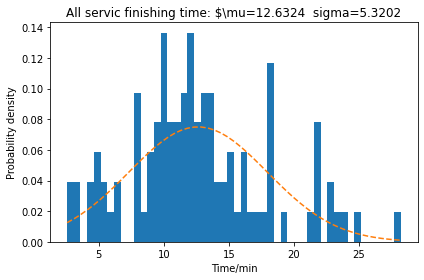

In [167]:
x0 = []
for i in range(100):
    for _ in range(100):
        x1 = []
        x1.append(simulation.run(n_customers=1))
    x0.append(np.mean(x1))
x = np.array(x0)
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [142]:
class simulation1:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=2, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=3, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            # print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [148]:
simulation1.run(n_customers=10)

48.18714539783477